# CCTA Dataset Creation: HU Subdivision

## 1. Create dataframes collecting the coronary ostia's world coordinates

---

In [ ]:
%cd ../

/home/marco/contrast-gan-3D


In [ ]:
from contrast_gan_3D.dataset import utils as dset_utils
from contrast_gan_3D.utils import geometry, logging_utils

logging_utils.set_project_loggers_level(level="DEBUG")

contrast_gan_3D.utils.io_utils: INFO -> DEBUG
contrast_gan_3D.dataset.utils: INFO -> DEBUG
contrast_gan_3D.utils.geometry: INFO -> DEBUG


Adjust the variables in the following cell to match your setup. Run this code multiple times to process different datasets.

In [ ]:
from pathlib import Path
from pprint import pprint

DATASET_DIRS = [
    Path("/home/marco/data") / p
    for p in ["ASOCA_Philips/images", "MMWHS/ct_train", "MMWHS/ct_test"]
]

CENTERLINES_TOP_DIRS = [dir / "auto_centerlines" for dir in DATASET_DIRS]

# NOTE set to `None` if you don't want to write the dataframe to disk
OSTIA_DF_SAVENAMES = [dir / "ostia_world_coords.xlsx" for dir in DATASET_DIRS]

pprint(DATASET_DIRS)
pprint(CENTERLINES_TOP_DIRS)
pprint(OSTIA_DF_SAVENAMES)

[PosixPath('/home/marco/data/ASOCA_Philips/images'),
 PosixPath('/home/marco/data/MMWHS/ct_train'),
 PosixPath('/home/marco/data/MMWHS/ct_test')]
[PosixPath('/home/marco/data/ASOCA_Philips/images/auto_centerlines'),
 PosixPath('/home/marco/data/MMWHS/ct_train/auto_centerlines'),
 PosixPath('/home/marco/data/MMWHS/ct_test/auto_centerlines')]
[PosixPath('/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx'),
 PosixPath('/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx'),
 PosixPath('/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx')]


In [ ]:
for centerlines_dir, ostia_df_savename in zip(CENTERLINES_TOP_DIRS, OSTIA_DF_SAVENAMES):
    print(f"Centerlines: {str(centerlines_dir)!r} Ostias: {str(ostia_df_savename)!r}")

    ostia_paths = sorted(list(centerlines_dir.glob("*/ostia.xml")))

    ostia_dataframe = dset_utils.create_ostia_dataframe(
        ostia_paths, ostia_sheet_savename=ostia_df_savename
    )
    display(ostia_dataframe.head())

Centerlines: '/home/marco/data/ASOCA_Philips/images/auto_centerlines' Ostias: '/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx'
[2024-01-18 16:45:53,331: INFO] Total L/R ostia coordinates: (120, 3) (contrast_gan_3D.dataset.utils:22)


[2024-01-18 16:45:53,718: INFO] Saved ostia world coordinates to '/home/marco/data/ASOCA_Philips/images/ostia_world_coords.xlsx' (contrast_gan_3D.dataset.utils:35)


,id,x,y,z
0,ASOCA-000,212,211,-103
1,ASOCA-000,219,240,-93
2,ASOCA-001,177,260,-95
3,ASOCA-001,189,287,-83
4,ASOCA-002,189,229,-110


Centerlines: '/home/marco/data/MMWHS/ct_train/auto_centerlines' Ostias: '/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx'
[2024-01-18 16:45:53,738: INFO] Total L/R ostia coordinates: (40, 3) (contrast_gan_3D.dataset.utils:22)
[2024-01-18 16:45:53,762: INFO] Saved ostia world coordinates to '/home/marco/data/MMWHS/ct_train/ostia_world_coords.xlsx' (contrast_gan_3D.dataset.utils:35)


,id,x,y,z
0,ct_train_1001_image,38,276,-179
1,ct_train_1001_image,44,306,-163
2,ct_train_1002_image,0,224,-141
3,ct_train_1002_image,19,246,-129
4,ct_train_1003_image,7,311,-166


Centerlines: '/home/marco/data/MMWHS/ct_test/auto_centerlines' Ostias: '/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx'
[2024-01-18 16:45:53,774: INFO] Total L/R ostia coordinates: (80, 3) (contrast_gan_3D.dataset.utils:22)
[2024-01-18 16:45:53,793: INFO] Saved ostia world coordinates to '/home/marco/data/MMWHS/ct_test/ostia_world_coords.xlsx' (contrast_gan_3D.dataset.utils:35)


,id,x,y,z
0,ct_test_2001_image,-4,183,-105
1,ct_test_2001_image,9,206,-89
2,ct_test_2002_image,23,167,-104
3,ct_test_2002_image,12,142,-114
4,ct_test_2003_image,-5,230,-142


## 2. Divide the datapoints in optimal and suboptimal HU contrast values

CCTA scans are divided into *optimal* and *suboptimal* sets based on the contrast medium attenuation values at the 
aortic root. We fit a Mixture of Gaussians model on a 3D patch centered around the aortic root, and identify its 
attenuation value as the component with the highest mean HU value.

This data processing approach is described in 
"[Generative Adversarial Networks for Coronary CT Angiography Acquisition Protocol Correction with Explicit Attenuation Constraints (Van Herten, 2023)](https://openreview.net/pdf?id=MIHF_buWGUQ)"; the following code implementation is adapted from the first author's original codebase.

---

Adjust the variables in the following cell to match your setup:

In [ ]:
DATASET_NAMES = ["ASOCA", "MMWHS", "MMWHS"]
OSTIA_DATASET_PATH = Path("/home/marco/data/ostia_world_coords.xlsx")

print(DATASET_NAMES)
print(OSTIA_DATASET_PATH)

['ASOCA', 'MMWHS', 'MMWHS']
/home/marco/data/ostia_world_coords.xlsx


In [ ]:
import pandas as pd

if not OSTIA_DATASET_PATH.is_file():
    df = pd.concat(
        [
            pd.read_excel(path).assign(dataset=dataset_name)
            for path, dataset_name in zip(OSTIA_DF_SAVENAMES, DATASET_NAMES)
        ]
    )
    df.to_excel(OSTIA_DATASET_PATH, index=False)
    print("Saved ostia dataset")
else:
    df = pd.read_excel(OSTIA_DATASET_PATH)
    print("Loaded ostia dataset")

df

Loaded ostia dataset


,id,x,y,z,dataset
0,ASOCA-000,212,211,-103,ASOCA
1,ASOCA-000,219,240,-93,ASOCA
2,ASOCA-001,177,260,-95,ASOCA
3,ASOCA-001,189,287,-83,ASOCA
4,ASOCA-002,189,229,-110,ASOCA
...,...,...,...,...,...
235,ct_test_2038_image,14,214,-174,MMWHS
236,ct_test_2039_image,-4,110,-115,MMWHS
237,ct_test_2039_image,8,142,-105,MMWHS
238,ct_test_2040_image,16,303,-126,MMWHS


In [ ]:
from pprint import pprint

SAMPLES_DIR = Path("/home/marco/data/dataset_samples/")
samples = sorted(SAMPLES_DIR.glob("*.h5"))
pprint(samples)

cadrads_df = pd.read_excel("/home/marco/data/IDR_CADRADS/ostia.xlsx")
cadrads_df.head()

# (
#     cadrads_path,
#     cadrads_df,
# ) = "/home/marco/data/IDR_CADRADS/image/image3106/3106.h5", pd.read_excel(
#     "/home/marco/data/IDR_CADRADS/ostia.xlsx"
# )
# asoca_path = "/home/marco/data/ASOCA_Philips/images/ASOCA-040.h5"
# mmwhs_path = "/home/marco/data/MMWHS/ct_train/ct_train_1007_image.h5"

[PosixPath('/home/marco/data/dataset_samples/3107.h5'),
 PosixPath('/home/marco/data/dataset_samples/ASOCA-003.h5'),
 PosixPath('/home/marco/data/dataset_samples/ct_test_2002_image.h5'),
 PosixPath('/home/marco/data/dataset_samples/ct_test_2040_image.h5'),
 PosixPath('/home/marco/data/dataset_samples/ct_train_1001_image.h5'),
 PosixPath('/home/marco/data/dataset_samples/ct_train_1005_image.h5')]


,ID,ostium_x,ostium_y,ostium_z,mu,std
0,3085,23,-178,1252,573.105302,57.902959
1,3085,12,-200,1233,538.005343,87.082425
2,3086,4,-194,1237,523.857636,61.907001
3,3086,7,-166,1251,531.562540,52.082457
4,3088,10,-153,1157,631.225881,50.576542


/home/marco/data/dataset_samples/3107.h5


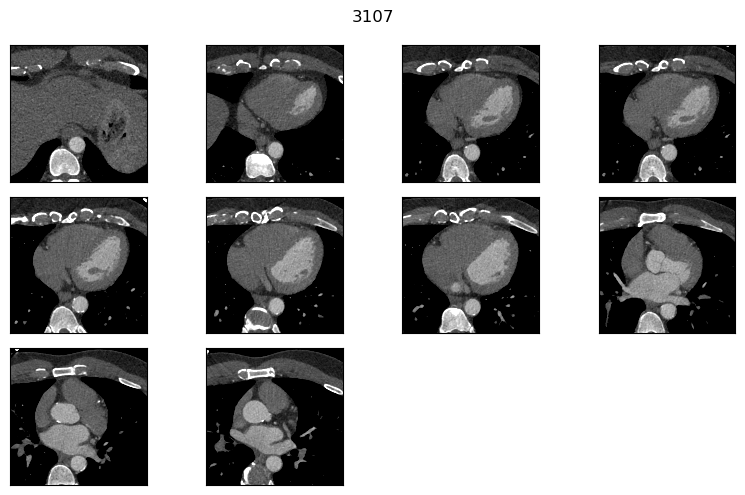

[2024-01-18 22:42:04,744: DEBUG] Clipped to (-1024, 3072) (contrast_gan_3D.utils.io_utils:33)


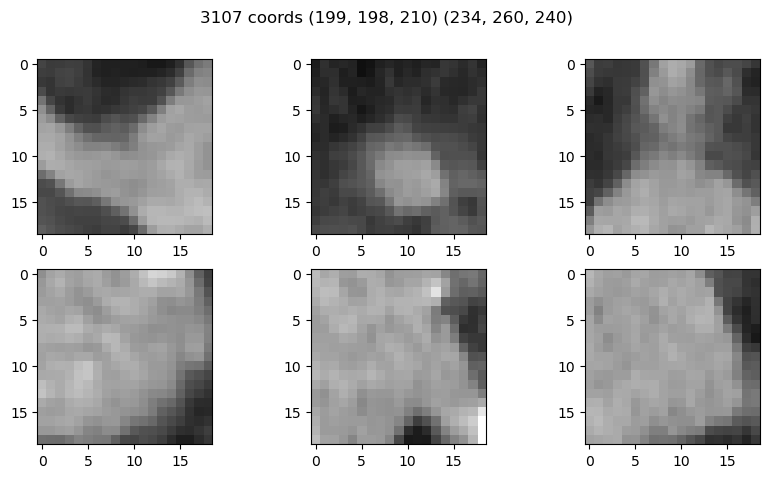

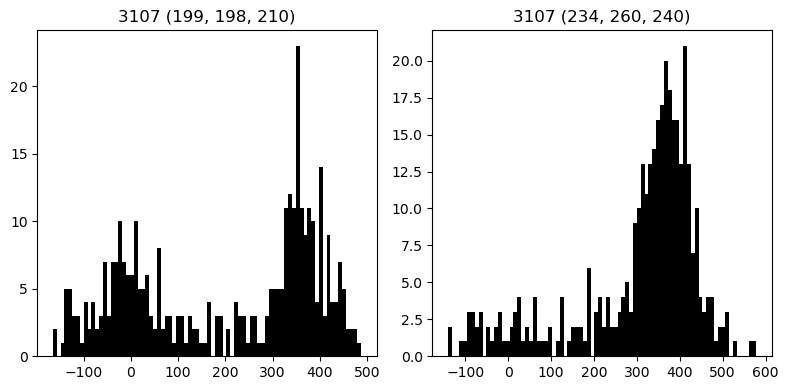

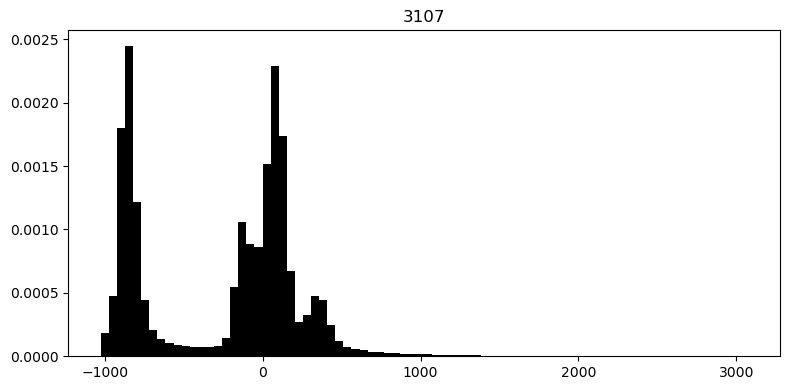

/home/marco/data/dataset_samples/ASOCA-003.h5


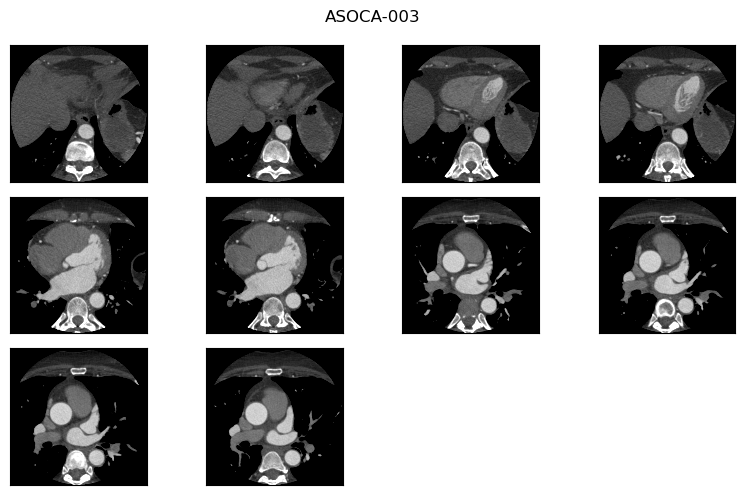

[2024-01-18 22:42:10,641: DEBUG] Clipped to (-1024, 3072) (contrast_gan_3D.utils.io_utils:33)


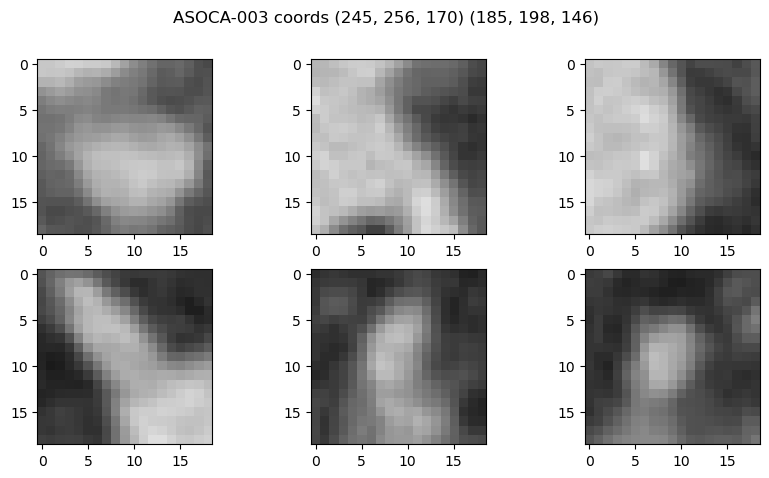

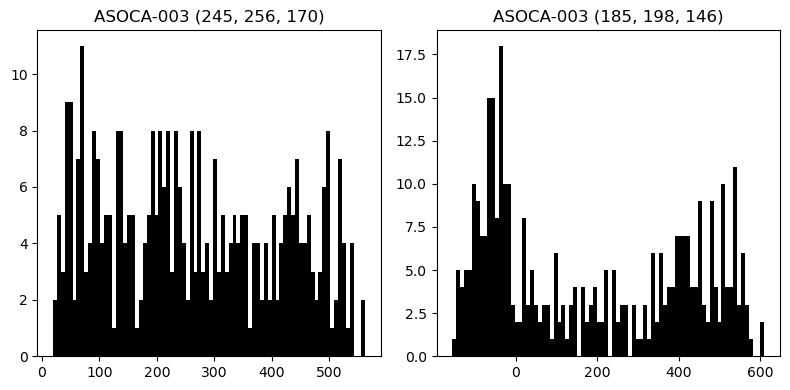

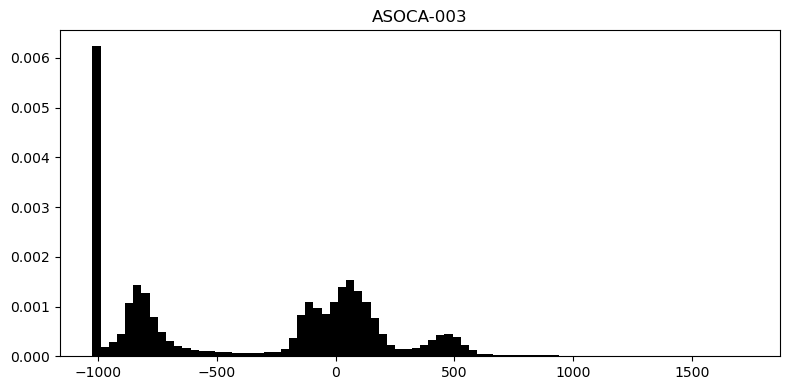

/home/marco/data/dataset_samples/ct_test_2002_image.h5


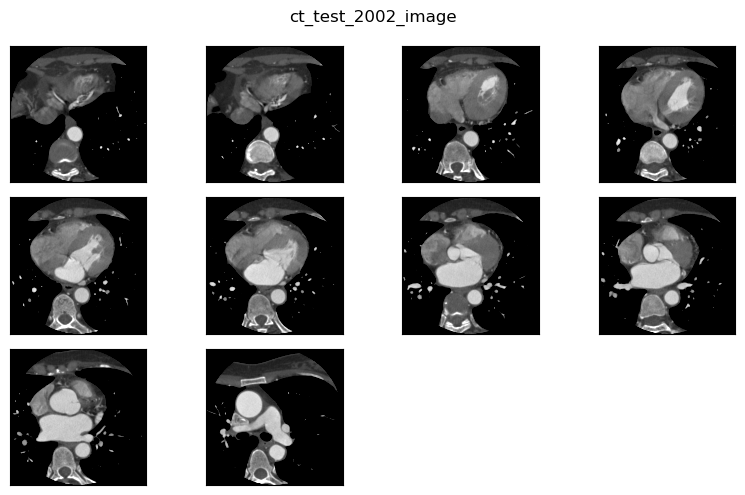

[2024-01-18 22:42:17,395: DEBUG] Clipped to (-1024, 3072) (contrast_gan_3D.utils.io_utils:33)


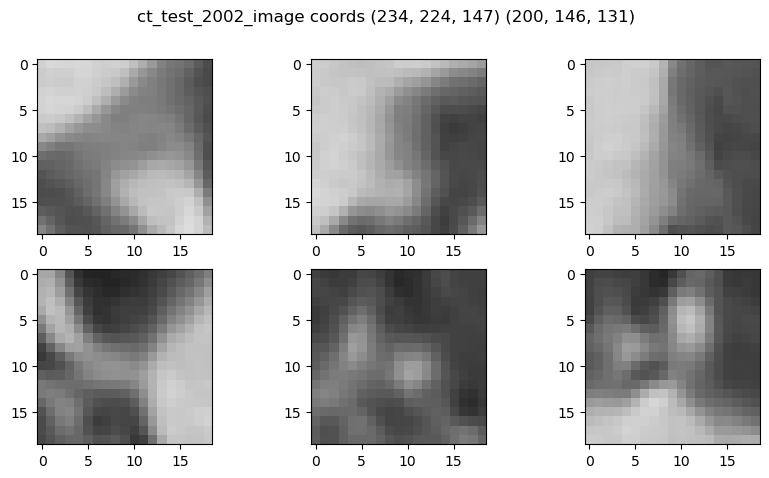

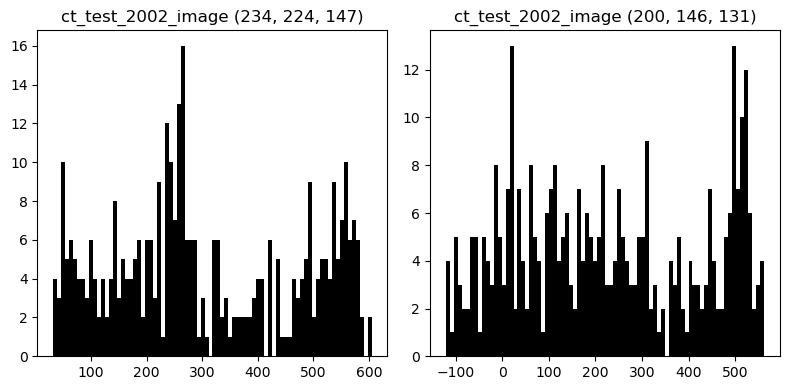

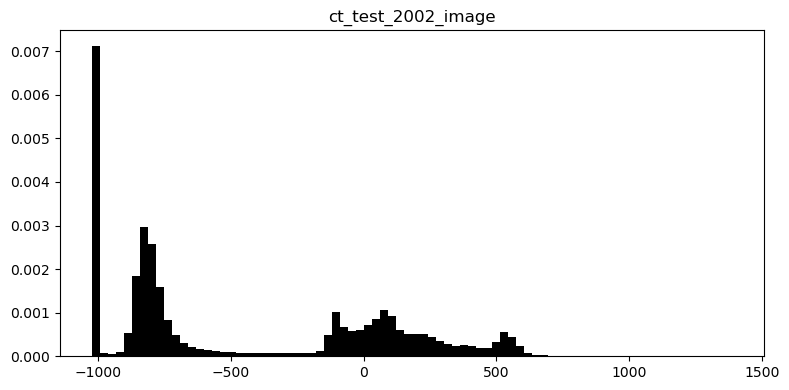

/home/marco/data/dataset_samples/ct_test_2040_image.h5


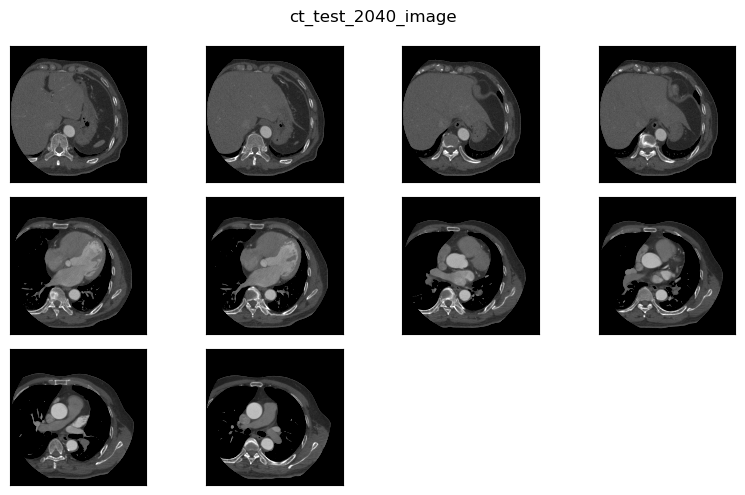

[2024-01-18 22:42:23,122: DEBUG] Clipped to (-1024, 3072) (contrast_gan_3D.utils.io_utils:33)


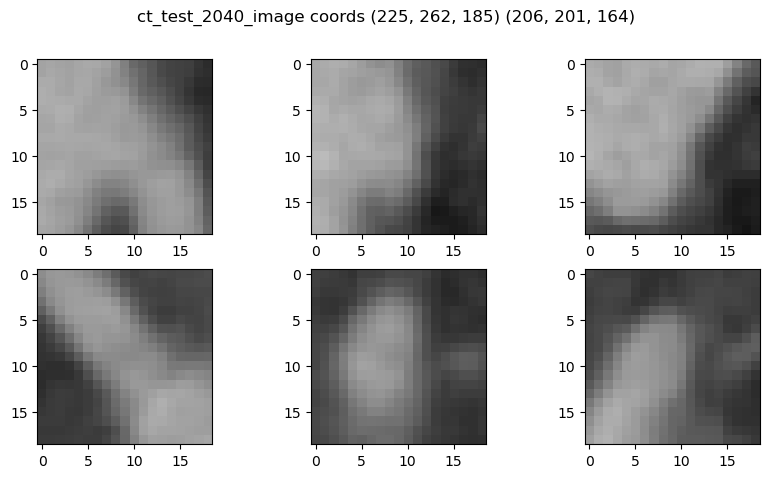

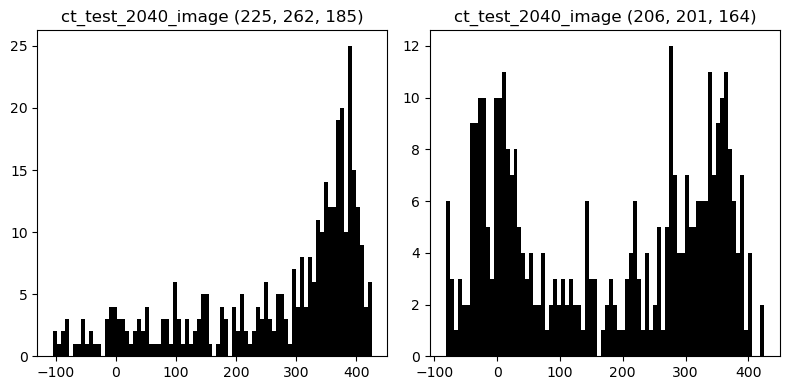

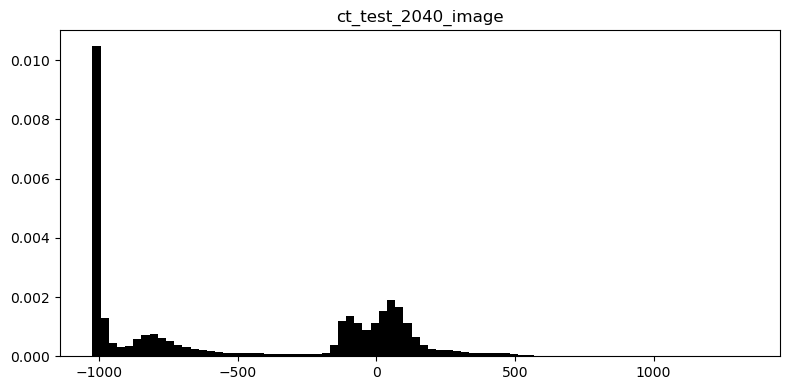

/home/marco/data/dataset_samples/ct_train_1001_image.h5


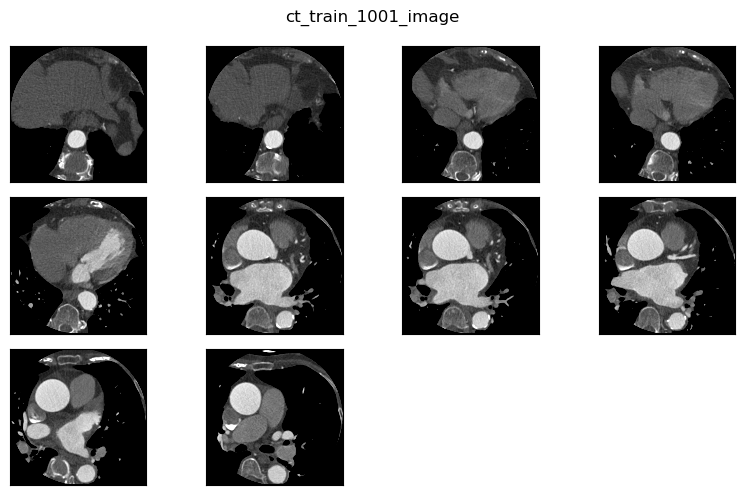

[2024-01-18 22:42:29,676: DEBUG] Clipped to (-1024, 3072) (contrast_gan_3D.utils.io_utils:33)


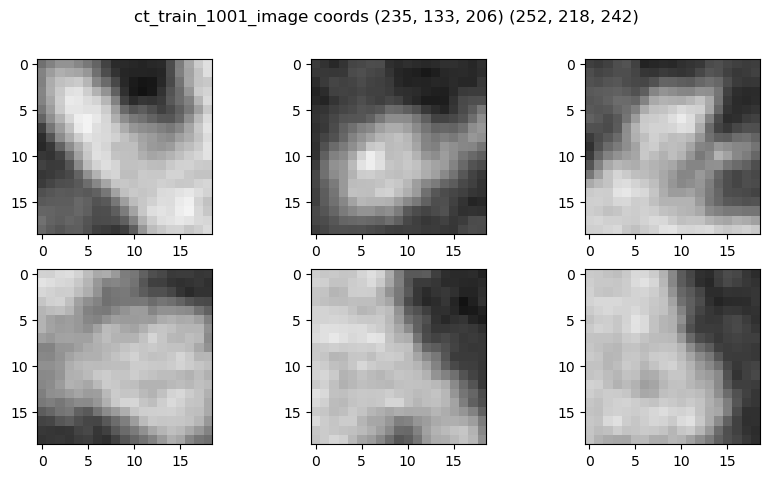

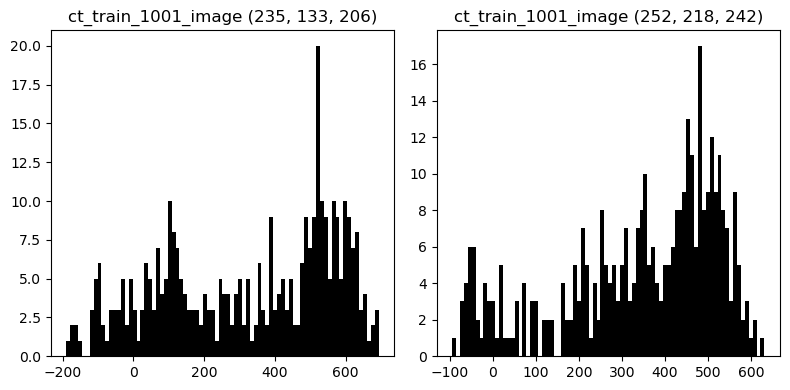

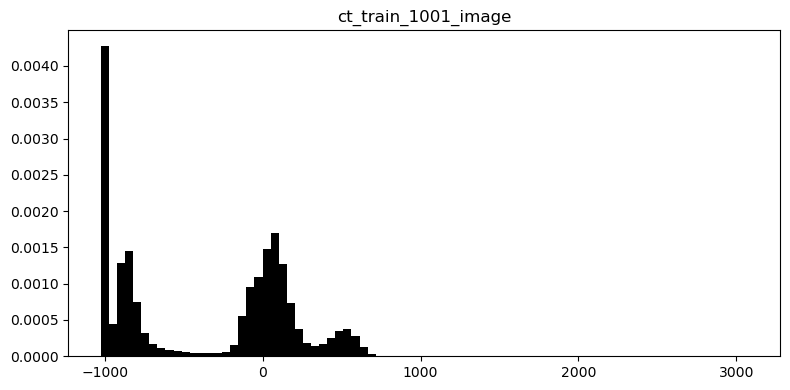

/home/marco/data/dataset_samples/ct_train_1005_image.h5


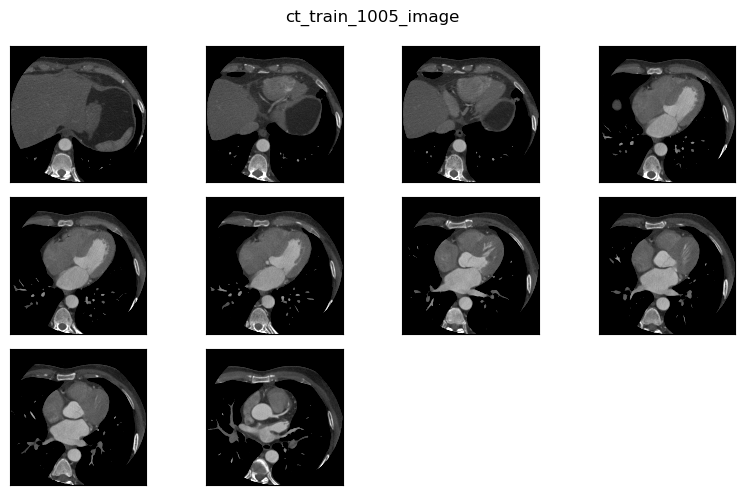

[2024-01-18 22:42:36,725: DEBUG] Clipped to (-1024, 3072) (contrast_gan_3D.utils.io_utils:33)


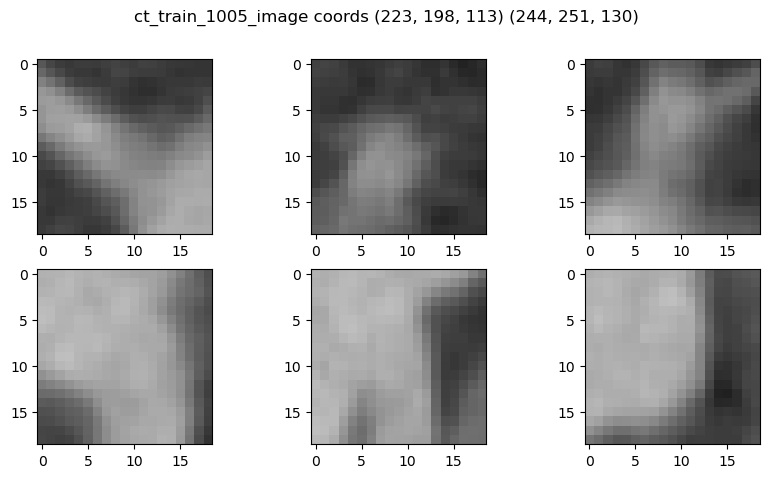

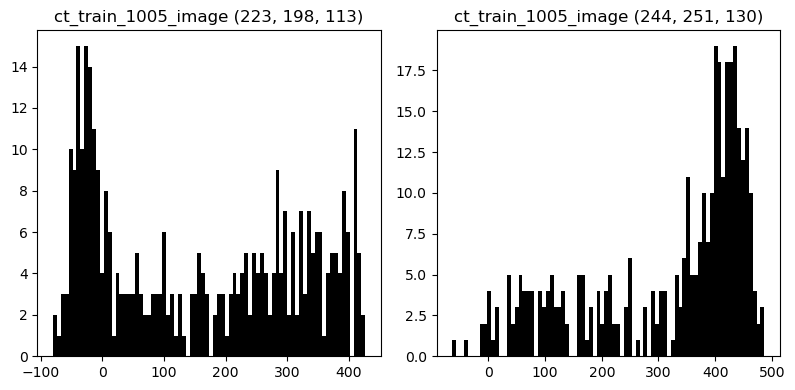

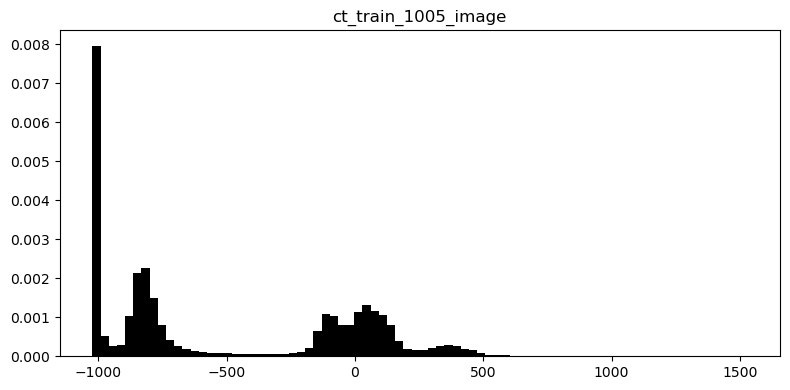

In [ ]:
from matplotlib import pyplot as plt
import numpy as np

from contrast_gan_3D.constants import VMIN, VMAX
from contrast_gan_3D.utils import io_utils, visualization

rng = np.random.default_rng()

for s in samples:
    print(s)

    is_cadrads = "ASOCA" not in str(s) and "ct_" not in str(s)
    img, meta, f = io_utils.load_h5_image(s, is_cadrads=is_cadrads)

    title = io_utils.stem(s)

    ids = sorted(rng.choice(img.shape[-1], 10, replace=False))
    axes = visualization.plot_axial_slices(
        img[..., ids], title=title, figsize=(8, 5), vmin=VMIN, vmax=VMAX
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    ostia_patches, ostia_world_coords = geometry.extract_ostia_patch_3D(
        img, meta, title, cadrads_df if is_cadrads else df, is_cadrads=is_cadrads
    )
    ostia_img_coords = geometry.world_to_image_coords(
        ostia_world_coords, meta["offset"], meta["spacing"]
    )
    title_coords0, title_coords1 = list(map(tuple, ostia_img_coords))
    axes = visualization.plot_ostia_patch(
        ostia_patches, title=f"{title} coords {title_coords0} {title_coords1}"
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    z_middle = ostia_patches.shape[-1] // 2
    axes = visualization.plot_image_histogram(
        (ostia_patches[0, ..., z_middle], f"{title} {title_coords0}"),
        (ostia_patches[1, ..., z_middle], f"{title} {title_coords1}"),
        tight=True,
        figsize=(8, 4),
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    axes = visualization.plot_image_histogram(
        (img[::], title),
        tight=True,
        figsize=(8, 4),
        density=True
    )
    plt.show()
    plt.close(axes[0, 0].get_figure())

    f.close()

In [ ]:
# NOTE taken from Roel's code

from IPython.display import display
from matplotlib import pyplot as plt
from scipy.stats import norm
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import GridSearchCV

DATA_ROOT = Path("/home/marco/data/IDR_CADRADS/image")
CENTERLINES_DIR = Path("/home/roel/output/IDR_CADRADS/graphprep/NilsOrigin/default")
DATA_ROOT, CENTERLINES_DIR


def gmm_model_selection(patch1D, max_n_components, show=False):
    grid_search = GridSearchCV(
        GMM(max_iter=1000, random_state=10, covariance_type="full"),
        param_grid={"n_components": range(1, max_n_components)},
        scoring=lambda estimator, X: -estimator.bic(X),
    ).fit(patch1D)
    d = pd.DataFrame(grid_search.cv_results_)[["param_n_components", "mean_test_score"]]
    d["mean_test_score"] = -d["mean_test_score"]
    d = d.rename(columns={"mean_test_score": "BIC score"})
    d = d.sort_values(by="BIC score")
    if show:
        display(d)
    return grid_search, grid_search.best_estimator_


def fit_mixture(array, ax, max_n_components=6):
    # find the optimal number of components
    _, gmm = gmm_model_selection(array, max_n_components)
    print("Optimal # components:", gmm.n_components)

    # calculate mean HU value and its std across components
    mu, std = gmm.means_.squeeze(), np.sqrt(gmm.covariances_.squeeze())

    # histogram of the (flattened) HU values of the 3D patch
    ax.hist(array, density=True, color="black", bins=100)
    # evaluate and plot the components distributions found via GMM
    x_axis = np.arange(-300, 900, 10)
    y_axis = np.vstack(
        [norm.pdf(x_axis, m, s) * w for m, s, w in zip(mu, std, gmm.weights_)]
    )
    ax.plot(x_axis, y_axis.sum(0), lw=3, c=f"C{max_n_components}", ls="dashed")
    for i in range(len(mu)):
        ax.plot(x_axis, y_axis[i], lw=3, c=f"C{i}")

    # assumption: the contrast media provides highest HU values in the patch
    ind = mu.argmax()  # initialize most dominant component
    mu, std = mu.tolist(), std.tolist()
    print("Mu ->", mu)
    print("Std ->", std)
    if min(std) > 100:
        mu_ = np.array(mu) - 400
        ind = np.abs(mu_).argmin()
        print(
            f"Lowest std {min(std)} > 100, pick component {ind} the argmin of {np.abs(np.array(mu) - 400)}"
        )
        print(mu[ind], std[ind])
    else:
        # maybe these are artifacts?
        while std[ind] > 150:
            print(f"Skip component {ind} mu {mu[ind]}, std {std[ind]} > 150")
            mu.pop(ind)
            std.pop(ind)
            ind = np.array(mu).argmax()

    mu, std = mu[ind], std[ind]
    print("mu", mu, "std", std, "component", ind)
    print("----")
    return mu, std


def plot_25(array_3d):
    middle = [v // 2 for v in array_3d.shape]

    # plot 3 views of the center of the patch
    _, ax = plt.subplots(1, 4, figsize=(22, 5))
    ax[0].imshow(array_3d[middle[0], :, :], vmin=VMIN, vmax=VMAX, cmap="gray")
    ax[1].imshow(array_3d[:, middle[1], :], vmin=VMIN, vmax=VMAX, cmap="gray")
    ax[2].imshow(array_3d[:, :, middle[2]], vmin=VMIN, vmax=VMAX, cmap="gray")

    ret = fit_mixture(array_3d.reshape(-1, 1), ax[3])

    plt.show()

    return ret